# Model building and validation

In this notebook we are going to load the already processed data and feed it to two different models, to check which of the models is giving us better results. We are going to use the test set which was saved at the beginning of the experiment to test the best model on the training set.

We will use two approaches, model building from scratch using a simple deep learning architecture and transfer learning to VGG16. Once we have checked the model that give us the best results, we will predict the test set and that will be our final result of the experiment. Based on that we can extract our conclusions and next steps for this problem.
Another step we could add to this notebook if we had time is model explainability, checking what the model is looking for in the different classes and images to spot any configuration or processing step we could add to the data to simplify the prediction.

**Objectives**
- Loading the data from the EDA step
- Do any further processing in order to feed it to the different models
- Create a basic models using keras layers and train it from scratch for this problem
- Use transfer learning to train a VGG16 model for this task
- Use the best model in terms of Accuracy with the test set

**Conclusions**
- Training data and validation was loaded smoothly
- The creation of the model from scratch was straightforward and brought good results!
- I started doing the transfer learning to VGG-16 but it involved a lot of preprocessing and different problems started to arised. As I had a model already working I decided to move forward with that one and leave the VGG-16 approach for another time.
- An important improvement will be to add all the preprocessing steps into a scikit learn pipeline or directly into the layers of the keras model, as we only have the rescaling and the grouping of the labels these can be done separatedly, but if we were to have more it would be a good point
- Accuracy for the test seems quite good for the model and data augmentation that we have used, having less precission in the classes 1 and 2. This will need investigating, maybe checking the model explainability, or upsampling those classes even further as they are ones of the minority ones.
- Final accuracy for the test set is: 95% which is pretty good!
- Conclusions for deployment is that we have to take into time the prediction time of the model, depending on the usage that we are going to give it.

## Imports & Watermark

In [1]:
%load_ext watermark
import random
import numpy as np
import seaborn as sns
import warnings
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from centric.dataset import rescale_data
from centric.dataset import group_labels
from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

2023-10-08 22:01:19.445931: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%watermark

Last updated: 2023-10-08T22:01:23.294230+02:00

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.16.1

Compiler    : Clang 13.0.0 (clang-1300.0.29.30)
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [3]:
%watermark --iversions

numpy     : 1.26.0
tensorflow: 2.14.0
keras     : 2.14.0
matplotlib: 3.8.0
seaborn   : 0.13.0



## Loading training and validation data

We are going to load the training and validation data that we saved before, we are going to rescale the validation data and start with the model building and validation

In [4]:
X_train = np.load("../data/train_images.npy")
y_train = np.load("../data/train_labels.npy")

assert X_train.shape == (62400, 28, 28), "Not the shape we were expecting for the training set."
assert y_train.shape == (62400,), "Not the shape we were expecting for the training labels."

In [5]:
X_val = np.load("../data/validation_images.npy")
y_val = np.load("../data/validation_labels.npy")

X_val = rescale_data(X_val)

## 1st approach - Small model from scratch

We are going to create a deep learning model from scratch, adding our own layers and use the validation data to train and optimize it. We will also use an early stopping approach.
This approach is a simple approach when we want an easy model that we know what is roughly doing so that we can modify it at our taste.


If we were to productionize this model we would need to put these steps into the source code, but as this is a exploratory notebook and we are still testing which approach to take and modifying some of the parameters I've decided to just leave it here and explain what we are doing in the notebook.

We have built the model from scratch and trained it, optimizing it with the Adam approach, using an early stopping mechanism which has worked, as we set 10 epochs but it has only done 6, meaning that the model was starting to over fit.

The accuracy for the validation has been: 0.95 which is not bad at all! We could spend much more time here, like adding a dropout layer to reduce the overfitting.


In [6]:
num_classes = len(np.unique(y_train))
scratch_model = Sequential([
  layers.Conv2D(16, 1, activation='relu', input_shape=(28, 28, 1)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 1, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 1, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [7]:
scratch_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        32        
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        544       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          2112      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 64)         

In [8]:
scratch_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=1)
epochs=10
history = scratch_model.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  epochs=epochs,
  callbacks = [es]
)

Epoch 1/10
1950/1950 [==============================] - 12s 6ms/step - loss: 0.4462 - accuracy: 0.8380 - val_loss: 0.2570 - val_accuracy: 0.9080
Epoch 2/10
1950/1950 [==============================] - 12s 6ms/step - loss: 0.2458 - accuracy: 0.9146 - val_loss: 0.1859 - val_accuracy: 0.9388
Epoch 3/10
1950/1950 [==============================] - 11s 6ms/step - loss: 0.1880 - accuracy: 0.9360 - val_loss: 0.1737 - val_accuracy: 0.9426
Epoch 4/10
1950/1950 [==============================] - 12s 6ms/step - loss: 0.1660 - accuracy: 0.9435 - val_loss: 0.1506 - val_accuracy: 0.9508
Epoch 5/10
1950/1950 [==============================] - 13s 7ms/step - loss: 0.1519 - accuracy: 0.9475 - val_loss: 0.1416 - val_accuracy: 0.9549
Epoch 6/10
1950/1950 [==============================] - 12s 6ms/step - loss: 0.1403 - accuracy: 0.9522 - val_loss: 0.1355 - val_accuracy: 0.9562
Epoch 7/10
1950/1950 [==============================] - 17s 9ms/step - loss: 0.1306 - accuracy: 0.9552 - val_loss: 0.1465 - val_ac

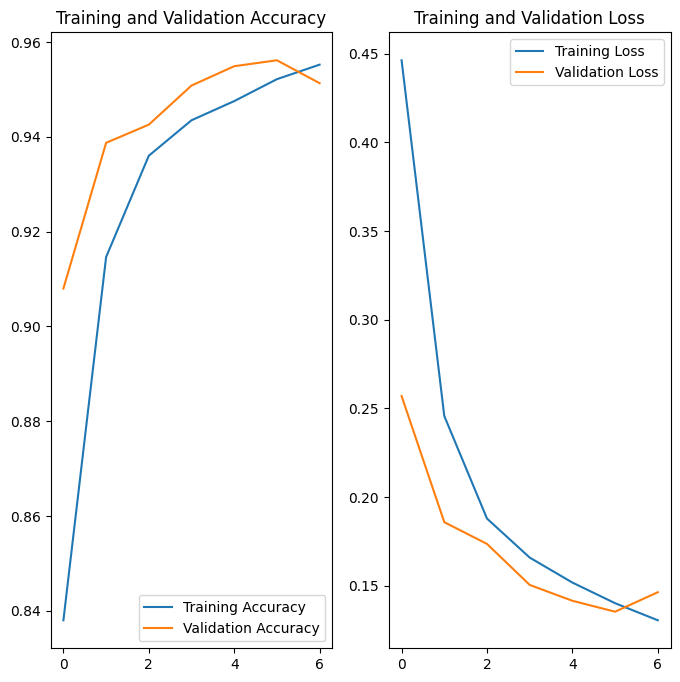

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Loading the test data and using it to validate our best model

We need to do the preprocessing steps for the test data and predict the labels using the model we have just trained.
We are going to check the metrics across the different classes to see if the up sampling and balancing of the classes worked at the end.

In [11]:
X_test = np.load("../data/holdout_images.npy")
y_test = np.load("../data/holdout_labels.npy")

In [12]:
# Preprocess pipeline
X_test = rescale_data(X_test)
y_test = group_labels(y_test)

In [13]:
y_pred = scratch_model.predict(X_test)

313/313 [==============================] - 1s 2ms/step


In [14]:
val_preds = np.argmax(y_pred, axis=1)

In [19]:
print(classification_report(y_test, val_preds))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      4000
           1       0.97      0.94      0.96      1000
           2       0.92      0.73      0.82      1000
           3       0.98      1.00      0.99      3000
           4       0.94      0.96      0.95      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.92      0.93     10000
weighted avg       0.95      0.95      0.95     10000



In [16]:
confusion_matrix(y_test, val_preds)

array([[3893,    8,   41,   11,   47],
       [  32,  940,   19,    5,    4],
       [ 207,   17,  732,   38,    6],
       [   0,    1,    0, 2991,    8],
       [  24,    2,    1,    9,  964]])

## Saving the model for future use

In [17]:
tf.keras.models.save_model(scratch_model,"../models/scratch_model.keras")